In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
import warnings
from collections import Counter

FileNotFoundError: Could not find module 'c:\Users\ttk8t\python\kokudo\.venv\Lib\site-packages\lightgbm\bin\lib_lightgbm.dll' (or one of its dependencies). Try using the full path with constructor syntax.

In [1]:
import pandas as pd
import numpy as np
df_train_2022 = pd.read_csv('../data/2022/train_2022.csv')
df_train_2021 = pd.read_csv('../data/2021/train_2021.csv')
df_train_2020 = pd.read_csv('../data/2020/train_2020.csv')
df_train_2019 = pd.read_csv('../data/2019/train_2019.csv')
test_df = pd.read_csv('../data/2023/test.csv')
train_df = pd.DataFrame()
train_df = pd.concat([df_train_2022,df_train_2021,df_train_2020,df_train_2019],axis=0)
train_df['log_money_room'] = np.log1p(train_df['money_room'])
train_df['nearest_price_pub'] = np.log1p(train_df['nearest_price_pub'])
test_df['nearest_price_pub'] = np.log1p(test_df['nearest_price_pub'])

C:\Users\ttk8t\AppData\Local\Temp\ipykernel_10836\1572744474.py:3: DtypeWarning: Columns (40,43,47,56,57,64,119,155,189,223,257,291,325,359,393,427,461) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train_2022 = pd.read_csv('../data/2022/train_2022.csv')
C:\Users\ttk8t\AppData\Local\Temp\ipykernel_10836\1572744474.py:4: DtypeWarning: Columns (40,41,43,47,56,57,64,65,66,95,117,119,155,189,223,257,291,325,359,393,427,461) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train_2021 = pd.read_csv('../data/2021/train_2021.csv')
C:\Users\ttk8t\AppData\Local\Temp\ipykernel_10836\1572744474.py:5: DtypeWarning: Columns (43,47,56,57,64,155,189,223,257,291,325,359,393,427,461) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train_2020 = pd.read_csv('../data/2020/train_2020.csv')
C:\Users\ttk8t\AppData\Local\Temp\ipykernel_10836\1572744474.py:6: DtypeWarning: Columns (43,47,56,57,64,155,189,223,257,291,32

KeyError: 'nearest_price_pub'

In [3]:
train_df.columns.tolist()

['Unnamed: 0',
 'target_ym',
 'money_room',
 'building_id',
 'building_status',
 'building_create_date',
 'building_modify_date',
 'building_type',
 'building_name',
 'building_name_ruby',
 'homes_building_name',
 'homes_building_name_ruby',
 'unit_count',
 'full_address',
 'lon',
 'lat',
 'building_structure',
 'total_floor_area',
 'building_area',
 'floor_count',
 'basement_floor_count',
 'year_built',
 'building_land_area',
 'land_area_all',
 'unit_area_min',
 'unit_area_max',
 'building_land_chimoku',
 'land_youto',
 'land_toshi',
 'land_chisei',
 'land_area_kind',
 'land_setback_flg',
 'land_setback',
 'land_kenpei',
 'land_youseki',
 'land_road_cond',
 'land_seigen',
 'building_area_kind',
 'management_form',
 'management_association_flg',
 'reform_exterior',
 'reform_exterior_other',
 'reform_exterior_date',
 'reform_common_area',
 'reform_common_area_date',
 'building_tag_id',
 'unit_id',
 'unit_name',
 'name_ruby',
 'room_floor',
 'balcony_area',
 'dwelling_unit_window_angle',

In [4]:
train_df['price_pub_nearest'] = np.log1p(train_df['price_pub_nearest'])
test_df['price_pub_nearest'] = np.log1p(test_df['price_pub_nearest'])
train_df['price_pub_mean_top5'] = np.log1p(train_df['price_pub_mean_top5'])
test_df['price_pub_mean_top5'] = np.log1p(test_df['price_pub_mean_top5'])
train_df['price_pub_median_top5'] = np.log1p(train_df['price_pub_median_top5'])
test_df['price_pub_median_top5'] = np.log1p(test_df['price_pub_median_top5'])
train_df['price_pub_min_top5'] = np.log1p(train_df['price_pub_min_top5'])
test_df['price_pub_min_top5'] = np.log1p(test_df['price_pub_min_top5'])
train_df['price_pub_max_top5'] = np.log1p(train_df['price_pub_max_top5'])
test_df['price_pub_max_top5'] = np.log1p(test_df['price_pub_max_top5'])

In [3]:
class FeatureProcessor:
    """train/testで一貫した前処理を行うクラス"""
    
    def __init__(self):
        self.top_tags = {}  # タグカラムごとの頻出タグリスト
        self.label_encoders = {}  # カテゴリカラムごとのLabelEncoder
        self.median_built = None
        self.cat_cols = [
            'building_type', 'building_structure', 'floor_plan_code', 
            'prefecture', 'city', 'nearest_pub_land_use','rosen_name1'
        ]
        self.use_cols = None
        self.tag_cols = []
        self.slashed_col = ["building_tag_id", "unit_tag_id","reform_interior", "reform_exterior", "reform_wet_area","statuses"]
    
    def get_slashed_tags(self,df):
        """スラッシュ区切りの値を持つ列を個別の列に変換する"""
        tag_master = pd.read_excel(f"../data/data_definition.xlsx",
                           sheet_name='③タグマスタ情報')
        tag_master = tag_master[['タグID', 'タグ内容']]
        tag_master["タグID"] = tag_master["タグID"].astype("str")
        tag_master.set_index('タグID', inplace=True)
        tag_master = tag_master.to_dict()['タグ内容']
        temp_dfs = []
        for col in self.slashed_col:
            temp_df = df[col].str.get_dummies(sep="/").astype("str")
            temp_df.rename(columns=tag_master, inplace=True)
            new_col_name = [f"{col} " + c for c in temp_df.columns]
            temp_df.columns = new_col_name
            temp_dfs.append(temp_df)
        temp_dfs = pd.concat(temp_dfs, axis=1)

        self.tag_cols += temp_dfs.columns.tolist()
        return temp_dfs
    
    def fit(self, df):
        """trainデータから変換ルールを学習"""
        df = df.copy()
        
        # 築年の中央値を記録
        self.median_built = df['year_built'].median()
        
        # LabelEncoderをfit
        df = self._extract_address(df)
        for col in self.cat_cols:
            if col in df.columns:
                self.label_encoders[col] = LabelEncoder()
                df[col] = df[col].astype(str).fillna('unknown')
                self.label_encoders[col].fit(df[col])
        
        return self
    
    def transform(self, df, is_train=True):
        """データを変換"""
        df = df.copy()
        
        # --- A. 日付・築年数処理 ---
        df['target_year'] = df['target_ym'] // 100
        df['target_month'] = df['target_ym'] % 100
        
        df['year_built'] = df['year_built'].fillna(self.median_built)
        df['built_year'] = df['year_built'] // 100
        df['built_month'] = df['year_built'] % 100
        
        df['building_age_months'] = (
            (df['target_year'] - df['built_year']) * 12 + 
            (df['target_month'] - df['built_month'])
        )
        df['building_age_months'] = df['building_age_months'].clip(lower=0)
        
        
        # --- C. 住所からの抽出 ---
        df = self._extract_address(df)
        
        # --- D. カテゴリカル変数のエンコード ---
        for col in self.cat_cols:
            if col in df.columns and col in self.label_encoders:
                df[col] = df[col].astype(str).fillna('unknown')
                le = self.label_encoders[col]
                known_classes = set(le.classes_)
                # 既知ならエンコード、未知なら-1
                df[col] = df[col].apply(
                    lambda x: le.transform([x])[0] if x in known_classes else -1
                )
        
        # --- E. 使用するカラムを選定 ---
        use_cols = [
            'building_age_months', 'unit_area', 'total_floor_area', 
            'lon', 'lat',
            'unit_count', 'floor_count', 'room_floor',
            'building_type', 'building_structure', 'floor_plan_code',
            'prefecture', 'city','price_pub_nearest','price_pub_mean_top5','price_pub_median_top5','price_pub_min_top5','price_pub_max_top5'
            ,'pub_road_width_nearest','pub_land_use_mode_top5','pub_land_use_nearest','pub_land_shape_nearest'
            ,'school_ele_distance','parking_distance','walk_distance1','rosen_name1'
        ]
        # タグフラグも追加
        use_cols += self.tag_cols
        self.use_cols = use_cols
        
        return df[use_cols]
    
    def fit_transform(self, df):
        """fitとtransformを同時に実行"""
        self.fit(df)
        return self.transform(df, is_train=True)
    
    def _extract_address(self, df):
        """住所から都道府県・市区町村を抽出"""
        df['prefecture'] = df['full_address'].str.extract(r'([^都道府県]+[都道府県])')
        df['city'] = df['full_address'].str.extract(r'[都道府県]([^市区町村]+[市区町村])')
        return df

In [4]:
# 前処理実行
processor = FeatureProcessor()
combined_df = pd.concat([train_df, test_df])
slashed_df = processor.get_slashed_tags(combined_df)

In [5]:
slashed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 476361 entries, 0 to 112436
Columns: 374 entries, building_tag_id 楽器相談 to statuses 350201
dtypes: object(374)
memory usage: 1.3+ GB


In [6]:
# 新しく生成された列名を保存
tag_columns = slashed_df.columns
# 抽出した特徴量を結合
combined_df = pd.concat([combined_df, slashed_df], axis=1)

In [7]:
# trainとtestに分割
train_df = combined_df[:len(train_df)]
test_df = combined_df[len(train_df):]

In [8]:
# 前処理実行
X_train = processor.fit_transform(train_df)
X_test = processor.transform(test_df, is_train=False)


In [9]:
X_train[processor.use_cols] = X_train[processor.use_cols].astype(float)
X_test[processor.use_cols] = X_test[processor.use_cols].astype(float)

In [10]:
y = train_df['log_money_room']
# モデルパラメータ
params = {
    "loss_function": "MAE",
    "task_type": "GPU",  # CPUで実行する場合は削除
    "random_seed": 2025,
    "verbose": 1000,
    "iterations": 5000
}
folds = KFold(n_splits=5, shuffle=True, random_state=42)

oof_preds = np.zeros(len(X_train))
test_preds = np.zeros(len(X_test))
models = []

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbosity': -1,
    'random_state': 42
}

for fold, (train_idx, val_idx) in enumerate(folds.split(X_train, y)):
    X_tr, y_tr = X_train.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X_train.iloc[val_idx], y.iloc[val_idx]
    
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)
    
    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=10000,
        valid_sets=[lgb_train, lgb_val],
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=0)
        ]
    )
    
    oof_preds[val_idx] = model.predict(X_val, num_iteration=model.best_iteration)
    
    # テストデータの予測（各foldの平均を取る）
    test_preds += model.predict(X_test, num_iteration=model.best_iteration) / folds.n_splits
    
    models.append(model)
    print(f"Fold {fold+1} RMSE: {model.best_score['valid_1']['rmse']:.4f}")

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[10000]	training's rmse: 0.147698	valid_1's rmse: 0.213152
Fold 1 RMSE: 0.2132
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[10000]	training's rmse: 0.147546	valid_1's rmse: 0.215063
Fold 2 RMSE: 0.2151
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[10000]	training's rmse: 0.147222	valid_1's rmse: 0.215332
Fold 3 RMSE: 0.2153
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[10000]	training's rmse: 0.147572	valid_1's rmse: 0.212885
Fold 4 RMSE: 0.2129
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[10000]	training's rmse: 0.147955	valid_1's rmse: 0.212046
Fold 5 RMSE: 0.2120


In [14]:
# ---------------------------------------------------------
# 4. 結果評価と特徴量重要度
# ---------------------------------------------------------
mae = mean_absolute_error(np.expm1(y), np.expm1(oof_preds))
print(f"\nOverall MAE: {mae:,.0f} JPY")

# 特徴量重要度の表示
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': np.mean([m.feature_importance(importance_type='gain') for m in models], axis=0)
}).sort_values('importance', ascending=False)

print("\nTop 10 Important Features:")
print(importance_df.head(10).to_string(index=False))

# ---------------------------------------------------------
# 5. 予測結果の出力
# ---------------------------------------------------------
# 対数を戻して実際の価格に変換
test_df['predicted_money_room'] = np.expm1(test_preds)

# 提出用ファイルの作成（必要なカラムに応じて調整）
submission = pd.DataFrame({
    'id': test_df.index if 'id' not in test_df.columns else test_df['id'],
    'money_room': test_df['predicted_money_room']
})
submission.to_csv('../data/submission.csv', index=False)

print(f"\nPrediction saved to submission.csv")
print(f"Prediction stats:")
print(f"  Min: {submission['money_room'].min():,.0f} JPY")
print(f"  Max: {submission['money_room'].max():,.0f} JPY")
print(f"  Mean: {submission['money_room'].mean():,.0f} JPY")


Overall MAE: 3,803,338 JPY

Top 10 Important Features:
            feature    importance
  nearest_price_pub 252741.622030
building_age_months 177566.829296
          unit_area 173168.751859
                lon  35428.630879
                lat  23584.487725
     statuses 浴室乾燥機  23008.276363
         prefecture  15688.062985
         room_floor  13239.411825
 dist_to_land_price  12671.996818
        floor_count  11312.006981


/tmp/ipykernel_10347/455687258.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['predicted_money_room'] = np.expm1(test_preds)



Prediction saved to submission.csv
Prediction stats:
  Min: 4,093,220 JPY
  Max: 196,132,311 JPY
  Mean: 25,622,026 JPY


In [ ]:
X_train

,building_age_months,unit_area,total_floor_area,lon,lat,unit_count,floor_count,room_floor,building_type,building_structure,floor_plan_code,prefecture,city,dist_to_land_price,nearest_pub_land_use,nearest_pub_road_width,nearest_price_pub
0,343.0,76.199997,76.199997,136.687322,35.072049,95.0,14.0,12.0,0,8,44,0,298,0.003158,2,60,11.144771
1,205.0,95.959999,95.959999,136.683116,35.058327,30.0,11.0,11.0,0,7,51,0,298,0.002146,7,140,11.335006
2,283.0,79.489998,NaN,136.693152,35.063285,1.0,1.0,NaN,8,1,48,0,298,0.003670,2,60,11.144771
3,289.0,117.830002,117.830002,136.622885,35.047964,NaN,1.0,NaN,8,1,51,0,298,0.007830,1,60,10.628642
4,309.0,114.739998,114.739998,136.626511,35.050545,NaN,2.0,NaN,8,1,51,0,298,0.005314,1,50,10.633473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82286,301.0,89.430000,NaN,136.646954,35.083805,NaN,2.0,NaN,8,1,51,0,298,0.005302,1,60,10.959558
82287,551.0,96.709999,96.709999,136.849117,34.934365,NaN,1.0,NaN,8,2,44,24,367,0.005750,1,60,10.992066
82288,282.0,163.080002,163.080002,136.659592,35.064696,NaN,2.0,NaN,8,6,58,0,298,0.007955,1,20,9.588845
82289,20.0,182.820007,182.820007,136.851469,34.933236,1.0,2.0,NaN,8,6,64,24,367,0.005436,1,60,10.992066


In [ ]:
import pandas as pd
importance = pd.DataFrame()
importance['feature'] = X_train.columns
importance['gain'] = models[0].feature_importance(importance_type='gain')
print("\nTop 10 Important Features:")
print(importance.sort_values(by='gain', ascending=False).head(10))


Top 10 Important Features:
                feature           gain
16    nearest_price_pub  258537.066785
0   building_age_months  202918.373547
1             unit_area  192210.518799
3                   lon   50639.429710
4                   lat   36889.951994
13   dist_to_land_price   19714.467023
11           prefecture   18819.395194
6           floor_count   17711.225868
10      floor_plan_code   14020.836712
12                 city   12843.673248


ImportError: You must install graphviz and restart your session to plot tree.

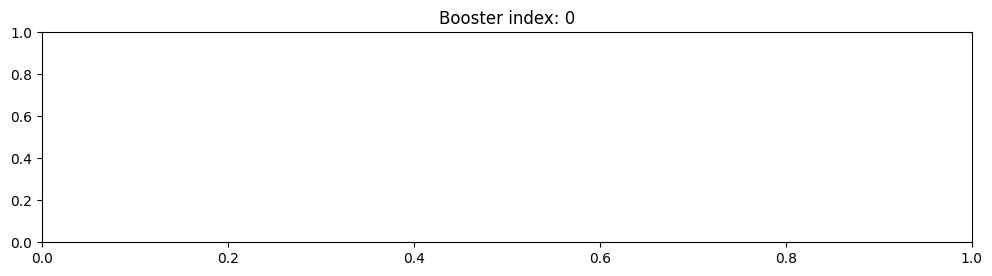

In [25]:
import matplotlib.pyplot as plt
rows = 2
cols = 1
fig = plt.figure(figsize=(12, 6))
for i in range(rows * cols):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(f'Booster index: {i}')
    lgb.plot_tree(booster=models[0],
                    tree_index=i,
                    show_info='internal_value',
                    ax=ax,
                    )
plt.show()